./images/mono_sorprendido.jpg: ✓ Cara detectada


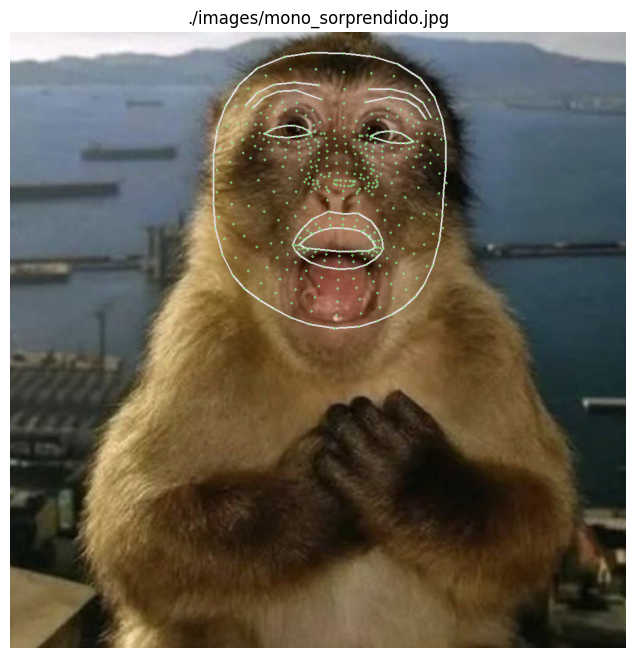

./images/mono_pensando.jpg: ✓ Cara detectada


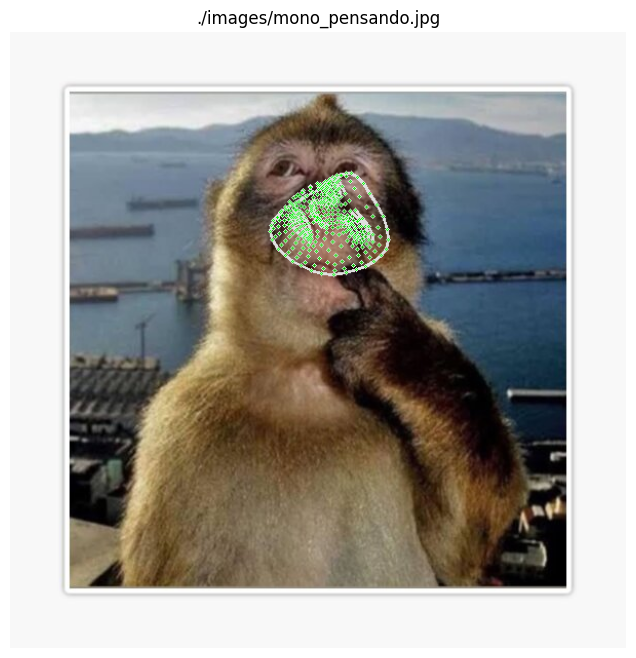

./images/mono_neutral.webp: ✓ Cara detectada


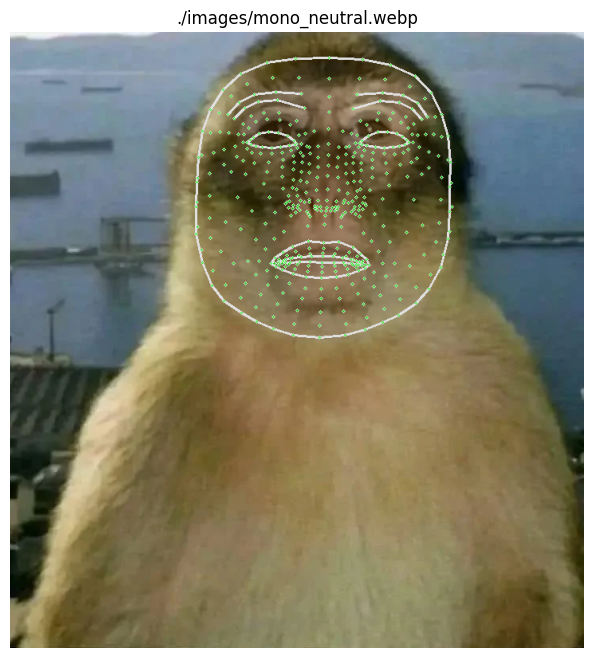

./images/mono_feliz.png: ✓ Cara detectada
./images/mono_feliz.png: ✓ Mano derecha detectada


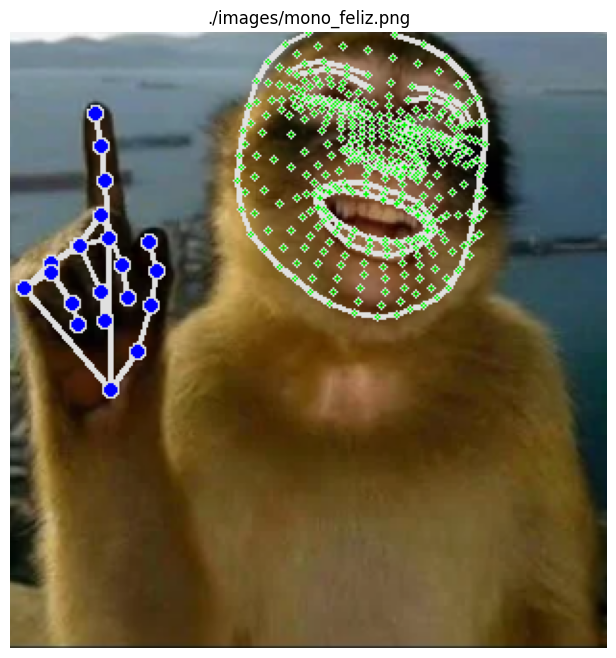

./images/mono_enfadado.jpg: ✗ Cara NO detectada


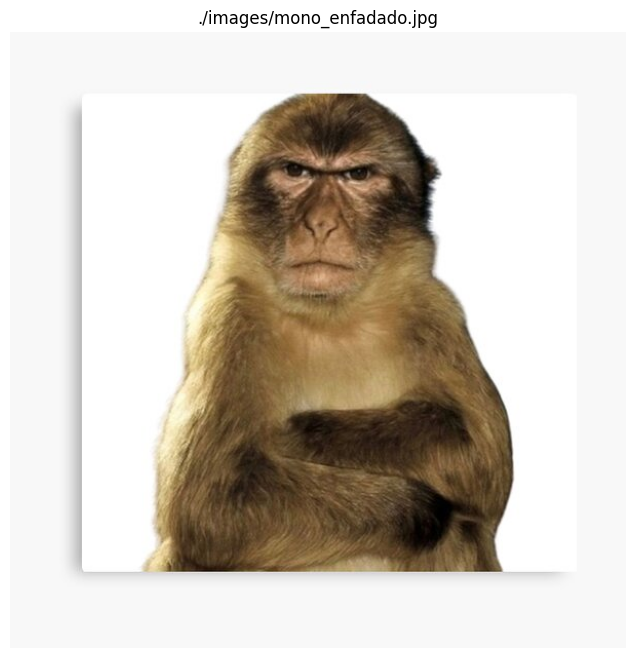

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Inicializar MediaPipe
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Configurar el modelo
holistic = mp_holistic.Holistic(
    static_image_mode=True,  # Para imágenes estáticas
    model_complexity=2,       # 0, 1 o 2 (mayor = más preciso pero más lento)
    min_detection_confidence=0.3,  # Bajado para monos
    min_tracking_confidence=0.3
)

# Lista de archivos
imagenes = [
    './images/mono_sorprendido.jpg',
    './images/mono_pensando.jpg',
    './images/mono_neutral.webp',
    './images/mono_feliz.png',
    './images/mono_enfadado.jpg'
]

# Procesar cada imagen
for img_path in imagenes:
    # Leer imagen
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Detectar
    results = holistic.process(image_rgb)
    
    # Dibujar detecciones
    annotated_image = image.copy()
    
    # Cara (468 landmarks)
    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.face_landmarks,
            mp_holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0,255,0), thickness=1, circle_radius=1)
        )
        print(f"{img_path}: ✓ Cara detectada")
    else:
        print(f"{img_path}: ✗ Cara NO detectada")
    
    # Mano derecha (21 landmarks)
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.right_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=2)
        )
        print(f"{img_path}: ✓ Mano derecha detectada")
    
    # Mano izquierda (21 landmarks)
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=2)
        )
        print(f"{img_path}: ✓ Mano izquierda detectada")
    
    # Mostrar resultado
    plt.figure(figsize=(10,8))
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.title(img_path)
    plt.axis('off')
    plt.show()
    
    # Guardar imagen procesada
    cv2.imwrite(f'detectado_{img_path}', annotated_image)

holistic.close()

In [17]:
import cv2
import mediapipe as mp
import numpy as np
from collections import deque, Counter

# Inicializar MediaPipe (compartido)
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

holistic = mp_holistic.Holistic(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# Cargar imágenes de los monos (compartido)
monos = {
    'neutral': cv2.imread('./images/mono_neutral.webp'),
    'feliz': cv2.imread('./images/mono_feliz.png'),
    'sorprendido': cv2.imread('./images/mono_sorprendido.jpg'),
    'pensando': cv2.imread('./images/mono_pensando.jpg'),
    'enfadado': cv2.imread('./images/mono_enfadado.jpg')
}

# Verificar carga
for nombre, img in monos.items():
    if img is None:
        print(f"No se pudo cargar: {nombre}")

# ========== FUNCIONES COMPARTIDAS ==========

def detectar_dedo_arriba(hand_landmarks):
    """Detecta si el dedo índice está levantado"""
    if hand_landmarks is None:
        return False
    landmarks = hand_landmarks.landmark
    indice_arriba = landmarks[8].y < landmarks[6].y - 0.03
    medio_doblado = landmarks[12].y > landmarks[10].y
    anular_doblado = landmarks[16].y > landmarks[14].y
    menique_doblado = landmarks[20].y > landmarks[18].y
    return indice_arriba and medio_doblado and anular_doblado and menique_doblado

def detectar_indice_en_boca(face_landmarks, hand_landmarks):
    """Detecta si la punta del dedo índice está cerca de la boca"""
    if face_landmarks is None or hand_landmarks is None:
        return False
    boca_x = face_landmarks.landmark[13].x
    boca_y = face_landmarks.landmark[13].y
    indice_punta_x = hand_landmarks.landmark[8].x
    indice_punta_y = hand_landmarks.landmark[8].y
    distancia = np.sqrt((boca_x - indice_punta_x)**2 + (boca_y - indice_punta_y)**2)
    return distancia < 0.08

def detectar_expresion(face_landmarks, hand_landmarks_left, hand_landmarks_right):
    """Detecta expresión facial y gestos de manos"""
    if face_landmarks is None:
        return 'neutral'
    
    landmarks = face_landmarks.landmark
    
    # BOCA
    labio_superior = landmarks[13].y
    labio_inferior = landmarks[14].y
    apertura_boca = abs(labio_inferior - labio_superior)
    
    # SONRISA
    comisura_izq_y = landmarks[61].y
    comisura_der_y = landmarks[291].y
    centro_boca_y = landmarks[13].y
    promedio_comisuras = (comisura_izq_y + comisura_der_y) / 2
    elevacion_sonrisa = centro_boca_y - promedio_comisuras
    
    # CEJAS
    ceja_izq = landmarks[52].y
    ceja_der = landmarks[282].y
    ojo_izq = landmarks[159].y
    ojo_der = landmarks[386].y
    distancia_cejas = ((ojo_izq - ceja_izq) + (ojo_der - ceja_der)) / 2
    
    # GESTOS DE MANOS
    dedo_arriba = (detectar_dedo_arriba(hand_landmarks_right) or 
                   detectar_dedo_arriba(hand_landmarks_left))
    indice_en_boca = (detectar_indice_en_boca(face_landmarks, hand_landmarks_right) or
                      detectar_indice_en_boca(face_landmarks, hand_landmarks_left))
    
    # LÓGICA DE DECISIÓN
    if elevacion_sonrisa > 0.004 and dedo_arriba:
        return 'feliz'
    if indice_en_boca:
        return 'pensando'
    if apertura_boca > 0.05:
        return 'sorprendido'
    if distancia_cejas < 0.025 and elevacion_sonrisa < 0.002:
        return 'enfadado'
    return 'neutral'

def redimensionar_imagen(img, alto_objetivo):
    """Redimensiona imagen manteniendo aspect ratio"""
    if img is None:
        return None
    h, w = img.shape[:2]
    ratio = alto_objetivo / h
    nuevo_ancho = int(w * ratio)
    return cv2.resize(img, (nuevo_ancho, alto_objetivo))

def superponer_mono_en_cara(frame, mono_img, face_landmarks):
    """Superpone la imagen del mono sobre la cara detectada"""
    if face_landmarks is None or mono_img is None:
        return frame
    
    h, w, _ = frame.shape
    landmarks = face_landmarks.landmark
    
    # Obtener bounding box de la cara
    x_coords = [int(landmark.x * w) for landmark in landmarks]
    y_coords = [int(landmark.y * h) for landmark in landmarks]
    
    # Márgenes para hacer el mono más grande
    margen_horizontal = 80
    margen_superior = 120
    margen_inferior = 80
    
    x_min = max(0, min(x_coords) - margen_horizontal)
    x_max = min(w, max(x_coords) + margen_horizontal)
    y_min = max(0, min(y_coords) - margen_superior)
    y_max = min(h, max(y_coords) + margen_inferior)
    
    ancho_cara = x_max - x_min
    alto_cara = y_max - y_min
    
    if ancho_cara <= 0 or alto_cara <= 0:
        return frame
    
    # Redimensionar mono
    mono_resized = cv2.resize(mono_img, (ancho_cara, alto_cara))
    resultado = frame.copy()
    
    # Opacidad alta (más opaco)
    alpha = 0.98
    roi = resultado[y_min:y_max, x_min:x_max]
    
    if roi.shape[:2] == mono_resized.shape[:2]:
        resultado[y_min:y_max, x_min:x_max] = cv2.addWeighted(
            roi, 1 - alpha, mono_resized, alpha, 0
        )
    
    return resultado

print("Funciones cargadas correctamente")


Funciones cargadas correctamente


In [18]:
# Iniciar webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: No se pudo abrir la webcam")
else:
    print("Webcam iniciada - Modo LADO A LADO")
    print("Gestos:")
    print("  FELIZ: Sonríe + levanta el dedo índice")
    print("  PENSANDO: Pon el dedo índice en la boca")
    print("  SORPRENDIDO: Abre mucho la boca")
    print("  ENFADADO: Frunce el ceño")
    print("  NEUTRAL: Cara relajada")
    print("\nPresiona 'q' para salir")

historial = deque(maxlen=3)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(image_rgb)
    
    annotated_frame = frame.copy()
    
    # Dibujar landmarks faciales
    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            annotated_frame,
            results.face_landmarks,
            mp_holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style()
        )
    
    # Dibujar landmarks de manos
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            annotated_frame,
            results.right_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style()
        )
    
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            annotated_frame,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style()
        )
    
    # Detectar expresión
    estado = detectar_expresion(
        results.face_landmarks,
        results.left_hand_landmarks,
        results.right_hand_landmarks
    )
    
    # Suavizado temporal
    historial.append(estado)
    estado_actual = Counter(historial).most_common(1)[0][0]
    
    # Obtener mono y redimensionar
    mono_img = monos.get(estado_actual, monos['neutral'])
    altura_frame = annotated_frame.shape[0]
    mono_resized = redimensionar_imagen(mono_img, altura_frame)
    
    if mono_resized is not None:
        # Texto con estado
        cv2.putText(annotated_frame, f"Estado: {estado_actual.upper()}", 
                    (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
        
        # Combinar lado a lado
        combined = np.hstack((annotated_frame, mono_resized))
    else:
        combined = annotated_frame
    
    cv2.imshow('Espejo de Emociones Mono - Lado a Lado', combined)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print("Finalizado - Modo Lado a Lado")


Webcam iniciada - Modo LADO A LADO
Gestos:
  FELIZ: Sonríe + levanta el dedo índice
  PENSANDO: Pon el dedo índice en la boca
  SORPRENDIDO: Abre mucho la boca
  ENFADADO: Frunce el ceño
  NEUTRAL: Cara relajada

Presiona 'q' para salir
Finalizado - Modo Lado a Lado


In [ ]:
# Iniciar webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: No se pudo abrir la webcam")
else:
    print("Webcam iniciada - Modo SUPERPOSICIÓN")
    print("Gestos:")
    print("  FELIZ: Sonríe + levanta el dedo índice")
    print("  PENSANDO: Pon el dedo índice en la boca")
    print("  SORPRENDIDO: Abre mucho la boca")
    print("  ENFADADO: Frunce el ceño")
    print("  NEUTRAL: Cara relajada")
    print("\nPresiona 'q' para salir")

historial = deque(maxlen=3)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(image_rgb)
    
    # Detectar expresión
    estado = detectar_expresion(
        results.face_landmarks,
        results.left_hand_landmarks,
        results.right_hand_landmarks
    )
    
    # Suavizado temporal
    historial.append(estado)
    estado_actual = Counter(historial).most_common(1)[0][0]
    
    # Obtener imagen del mono
    mono_img = monos.get(estado_actual, monos['neutral'])
    
    # Superponer mono sobre la cara
    frame_con_mono = superponer_mono_en_cara(frame, mono_img, results.face_landmarks)
    
    # Añadir texto con el estado
    cv2.putText(frame_con_mono, f"Estado: {estado_actual.upper()}", 
                (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
    
    cv2.imshow('Espejo de Emociones Mono - Superposición', frame_con_mono)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print("Finalizado - Modo Superposicion")


Webcam iniciada - Modo SUPERPOSICIÓN
Gestos:
  FELIZ: Sonríe + levanta el dedo índice
  PENSANDO: Pon el dedo índice en la boca
  SORPRENDIDO: Abre mucho la boca
  ENFADADO: Frunce el ceño
  NEUTRAL: Cara relajada

Presiona 'q' para salir
Finalizado - Modo Superposición
